##  Gridded Model Verification

This script verifies output from a ML-based foundation model versus a
traditional NWP system for the atmospheric system. The defaults set at the top of
this script are tailored to the Alps-Clariden HPC system at CSCS.
- The NWP-model is called DANRA-forecasts and is initialised with the analysis. Only surface level data is available, and up to 18 h lead time.
- The ML-model is called Neural-LAM and is initialised from the DANRA reanalysis.
- The Ground Truth is the same deterministic DANRA reanalysis as was used to train the ML-model.
- The boundary data for both models is IFS HRES from ECMWF, where the NWP-model got 6 hourly boundary updates (?) and the ML model 12 hourly.

In [2]:
import random
from pathlib import Path

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import dask
import matplotlib.pyplot as plt
from dask.distributed import LocalCluster, Client
import numpy as np
from dask.diagnostics import ProgressBar
import pandas as pd
import xarray as xr
from pysteps.verification.salscores import sal  # requires scikit-image
from scipy.stats import kurtosis, skew, wasserstein_distance
from scores.categorical import ThresholdEventOperator as TEO
from scores.continuous import (
    mae,
    mean_error,
    mse,
    rmse,
)
from scores.continuous.correlation import pearsonr
from scores.spatial import fss_2d

**--------> Enter all your user settings in the cell below. <--------**

In [ ]:
### DEFAULTS ###
# This config will be applied to the data before any plotting. The data will be
# sliced and indexed according to the values in this config.The whole analysis and
# plotting will be done on the reduced data.

# IF YOUR DATA HAS DIFFERENT DIMENSIONS OR NAMES, PLEASE ADJUST THE CELLS BELOW
# MAKE SURE THE XARRAY DATASETS LOOK OKAY BEFORE RUNNING CHAPTER 1-4

# This path should point to the data that was used to train the model (default is mdp-datastore)
PATH_GROUND_TRUTH = "danra_test_gt.zarr"
# This path should point to the NWP forecast data in zarr format
PATH_NWP = "danra_test_nwp_forecasts.zarr"
# This path should point to the ML forecast data in zarr format (e.g. produced by neural-lam in `eval` mode)
PATH_ML = "48h_eval_test_7deg_rect_hi4_2867.zarr"
# This path should point to the boundary data in zarr format (default is MDP-datastore)
PATH_BOUNDARY = "ifs_test_boundary.zarr"

# elapsed forecast duration in steps for the forecast - [0] refers to the first forecast step at t+1
# this should be a list of integers
ELAPSED_FORECAST_DURATION = list(range(16))
ELAPSED_FORECAST_DURATION_SHORT = list(range(6)) # 18 h, matching NWP forecasts
ELAPSED_FORECAST_DURATION_PLOT = [1,3,5] # ELS to plot
ELAPSED_FORECAST_DURATION_VERTICAL = [0, 3, 7, 11, 15] # For vertical profiles

# Select specific start_times for the forecast. This is the start and end of
# a slice in xarray. The start_time is included, the end_time is excluded.
# This should be a list of two strings in the format "YYYY-MM-DDTHH:MM:SS"
# Should be handy to evaluate certain dates, e.g. for a case study of a storm
#START_TIMES = ["2020-02-07T00:00:00", "2020-02-10T00:00:00"] # 7 init times, ~1% of full year
START_TIMES = ["2019-10-30T00:00", "2020-10-23T12:00"] # Full year, 720 init times

# Select specific plot times for the forecast (will be used to create maps for all variables)
# This only affect chapter one with the plotting of the maps
# Map creation takes a lot of time so this is limited to a single time step
# Simply rerun these cells and chapter one for more time steps
PLOT_TIME = "2020-02-09T12:00:00"

# Selection spatial grid in projection
# This is used to slice the data to a specific region
# This is in projection of the ground truth data
# The default is the whole domain [None, None]
X = [None, None]
Y = [None, None]

# Map projection settings for plotting
# This is the projection of the ground truth data
PROJECTION = ccrs.LambertConformal(
    central_longitude=25.0,
    central_latitude=56.7,
    standard_parallels=[56.7, 56.7],
    globe=ccrs.Globe(
        semimajor_axis=6367470.0,
        semiminor_axis=6367470.0,
    ),
)

# Define how variables map between different data sources

# Define here which of the variables are available in the ground truth data
# The keys are the names of the variables in the ground truth data
# The values are the conventional names, used in this notebook
VARIABLES_GROUND_TRUTH = {
    # Surface and near-surface variables
    "t2m": "temperature_2m",
    "u10m": "wind_u_10m",
    "v10m": "wind_v_10m",
    "pres_seasurface": "pressure_sea_level",
    "pres0m": "surface_pressure",
    "swavr0m": "surface_net_shortwave_radiation",
    "lwavr0m": "surface_net_longwave_radiation",
    # Upper air variables - U component
    "u100": "wind_u_100hPa",
    "u200": "wind_u_200hPa",
    "u400": "wind_u_400hPa",
    "u600": "wind_u_600hPa",
    "u700": "wind_u_700hPa",
    "u850": "wind_u_850hPa",
    "u925": "wind_u_925hPa",
    "u1000": "wind_u_1000hPa",
    # Upper air variables - V component
    "v100": "wind_v_100hPa",
    "v200": "wind_v_200hPa",
    "v400": "wind_v_400hPa",
    "v600": "wind_v_600hPa",
    "v700": "wind_v_700hPa",
    "v850": "wind_v_850hPa",
    "v925": "wind_v_925hPa",
    "v1000": "wind_v_1000hPa",
    # Upper air variables - Pressure
    "z100": "geopotential_100hPa",
    "z200": "geopotential_200hPa",
    "z400": "geopotential_400hPa",
    "z600": "geopotential_600hPa",
    "z700": "geopotential_700hPa",
    "z850": "geopotential_850hPa",
    "z925": "geopotential_925hPa",
    "z1000": "geopotential_1000hPa",
    # Upper air variables - Temperature
    "t100": "temperature_100hPa",
    "t200": "temperature_200hPa",
    "t400": "temperature_400hPa",
    "t600": "temperature_600hPa",
    "t700": "temperature_700hPa",
    "t850": "temperature_850hPa",
    "t925": "temperature_925hPa",
    "t1000": "temperature_1000hPa",
    # Upper air variables - Relative Humidity
    "r100": "relative_humidity_100hPa",
    "r200": "relative_humidity_200hPa",
    "r400": "relative_humidity_400hPa",
    "r600": "relative_humidity_600hPa",
    "r700": "relative_humidity_700hPa",
    "r850": "relative_humidity_850hPa",
    "r925": "relative_humidity_925hPa",
    "r1000": "relative_humidity_1000hPa",
    # Upper air variables - Vertical velocity
    "tw100": "vertical_velocity_100hPa",
    "tw200": "vertical_velocity_200hPa",
    "tw400": "vertical_velocity_400hPa",
    "tw600": "vertical_velocity_600hPa",
    "tw700": "vertical_velocity_700hPa",
    "tw850": "vertical_velocity_850hPa",
    "tw925": "vertical_velocity_925hPa",
    "tw1000": "vertical_velocity_1000hPa",
}

REQUIRED_LEVELS = [
    100,
    200,
    400,
    600,
    700,
    850,
    925,
    1000,
]

# Since the default ground_truth is the datastore that was used for model training
# the variables are identical to the VARIABLES_GROUND_TRUTH
VARIABLES_ML = VARIABLES_GROUND_TRUTH

# For the NWP-Forecast only a limited set of variables is available
# These variables are mapped to the same conventional names
# The script is flexible and will only calculate the NWP-metrics for the variables that are available
# The script will not break if some of the variables are not available
VARIABLES_NWP = {
    "t2m": "temperature_2m",
    "u10m": "wind_u_10m",
    "v10m": "wind_v_10m",
    "pres_seasurface": "seasurface_pressure",
}

# These variables are only used for chapter 1, the mapplots.
# They will be plotted for the ground truth, NWP and ML
VARIABLES_BOUNDARY = {
    # Surface and near-surface variables
    "mean_sea_level_pressure": "pressure_sea_level",
    "2m_temperature": "temperature_2m",
    "10m_u_component_of_wind": "wind_u_10m",
    "10m_v_component_of_wind": "wind_v_10m",
    "surface_pressure": "surface_pressure",
    # Upper air variables - U component
    "u_component_of_wind100": "wind_u_100hPa",
    "u_component_of_wind200": "wind_u_200hPa",
    "u_component_of_wind400": "wind_u_400hPa",
    "u_component_of_wind600": "wind_u_600hPa",
    "u_component_of_wind700": "wind_u_700hPa",
    "u_component_of_wind850": "wind_u_850hPa",
    "u_component_of_wind925": "wind_u_925hPa",
    "u_component_of_wind1000": "wind_u_1000hPa",
    # Upper air variables - V component
    "v_component_of_wind100": "wind_v_100hPa",
    "v_component_of_wind200": "wind_v_200hPa",
    "v_component_of_wind400": "wind_v_400hPa",
    "v_component_of_wind600": "wind_v_600hPa",
    "v_component_of_wind700": "wind_v_700hPa",
    "v_component_of_wind850": "wind_v_850hPa",
    "v_component_of_wind925": "wind_v_925hPa",
    "v_component_of_wind1000": "wind_v_1000hPa",
    # Upper air variables - Temperature
    "temperature100": "temperature_100hPa",
    "temperature200": "temperature_200hPa",
    "temperature400": "temperature_400hPa",
    "temperature600": "temperature_600hPa",
    "temperature700": "temperature_700hPa",
    "temperature850": "temperature_850hPa",
    "temperature925": "temperature_925hPa",
    "temperature1000": "temperature_1000hPa",
    # Upper air variables - Vertical velocity
    "vertical_velocity100": "vertical_velocity_100hPa",
    "vertical_velocity200": "vertical_velocity_200hPa",
    "vertical_velocity400": "vertical_velocity_400hPa",
    "vertical_velocity600": "vertical_velocity_600hPa",
    "vertical_velocity700": "vertical_velocity_700hPa",
    "vertical_velocity850": "vertical_velocity_850hPa",
    "vertical_velocity925": "vertical_velocity_925hPa",
    "vertical_velocity1000": "vertical_velocity_1000hPa",
    # Upper air variables - Geopotential
    "geopotential100": "geopotential_100hPa",
    "geopotential200": "geopotential_200hPa",
    "geopotential400": "geopotential_400hPa",
    "geopotential600": "geopotential_600hPa",
    "geopotential700": "geopotential_700hPa",
    "geopotential850": "geopotential_850hPa",
    "geopotential925": "geopotential_925hPa",
    "geopotential1000": "geopotential_1000hPa",
}


# These variables will be used as `basename` for the vertical profiles.
# Since the input of the zarr archives is expected to have data vars that are 2D in space
# we need some base_name prefix to create the 3D variables
VARIABLES_3D = [
    "wind_u",
    "wind_v",
    "geopotential",
    "temperature",
    "relative_humidity",
    "vertical_velocity",
]

# Add units dictionary after the imports
# units from zarr archives are not reliable and should rather be defined here
VARIABLE_UNITS = {
    # Surface and near-surface variables
    "temperature_2m": "K",
    "wind_u_10m": "m/s",
    "wind_v_10m": "m/s",
    "pressure_sea_level": "Pa",
    "surface_pressure": "Pa",
    "precipitation": "mm/h",
    #"surface_sensible_heat_flux": "W/m²",
    "surface_net_shortwave_radiation": "W/m²",
    "surface_net_longwave_radiation": "W/m²",
    # Upper air variables
    "wind_u_level": "m/s",
    "wind_v_level": "m/s",
    "geopotential_level": "m²/s²",
    "temperature_level": "K",
    "relative_humidity_level": "%",
    "vertical_velocity_level": "Pa/s",
}

# Define Thresholds for the ETS metric (Equitable Threat Score)
# These are calculated for wind and precipitation if available
# The score creates contingency tables for different thresholds
# The ETS is calculated for each threshold and the results are plotted
# The default thresholds are [0.1, 1, 5] for precipitation and [2.5, 5, 10] for wind
THRESHOLDS_PRECIPITATION = [0.1, 1, 5]  # mm/h
THRESHOLDS_WIND = [2.5, 5, 10]  # m/s

# Define the metrics to compute for the verification
# Some additional verifications will always be computed if the repsective vars
# are available in the data
METRICS = [
    # "MAE",
    "RMSE",
    # "MSE",
    "ME",
    "STDEV_ERR",
    "RelativeMAE",
    # "RelativeRMSE",
    # "PearsonR",
    # "Wasserstein",
]

# This setting is relevant for the mapplots in chapter 1
# Higher levels of ZOOM will zoom in on the map, cropping the boundary
BORDER_WIDTH = 300000 # in m
ZOOM = 1  # Unused

# For some chapters a random seed is required to reproduce the results
RANDOM_SEED = 42

# The DPI used in all plots in the notebook, export to pdf will always be 300 DPI
DPI = 100

# Subsample the data for faster plotting, 0.1 refers to 10% of the ml/nwp data
# sampled along the start_time, x and y dimensions. If you calculate the FSS
# metrics you would want to limit subsampling to the time-dimensions! There is a
# trade-off between speed and accuracy, that each user has to find.
SUBSAMPLE_FRACTION = 1.0

# If the data should be loaded into memory. Makes following calculations faster
# but requires enough memory to hold the data.
PRECOMPUTE_DATA = False

# Subsample the data for FSS threshold calculation, 1e7 refers to the number of elements
# This is not critical, as it is only used to calculate the 90% threshold
# for the FSS based on the ground truth data
SUBSAMPLE_FSS_THRESHOLD = 1e7

# Takes a long time, but if you see NaN in your output, you can set this to True
# This will check if there are any missing values in the data further below
# THIS NOTEBOOK WILL ONLY WORK RELIABLY IF THERE ARE NO MISSING VALUES
# If there are missing values, you have to interpolate them or remove them
CHECK_MISSING = False

# Font sizes for consistent plotting (different fig-sizes wil require different font sizes)
FONT_SIZES = {
    "axes": 24,  # Axis labels and titles
    "ticks": 24,  # Tick labels
    "legend": 22,  # Legend text
    "cbar": 24,  # Colorbar labels
    "suptitle": 24,  # Figure suptitle
    "title": 24,  # Axes titles
    "stats": 22,  # Statistics text in plots
}

In [4]:
# Create directories for plots and tables
Path("plots").mkdir(exist_ok=True)
Path("tables").mkdir(exist_ok=True)

# Colorblind-friendly color palette
COLORS = {
    "gt": "#000000",  # Black
    "ml": "#E69F00",  # Orange
    "nwp": "#56B4E9",  # Light blue
    "error": "#CC79A7",  # Pink
}

# Line styles and markers for accessibility
LINE_STYLES = {
    "gt": ("solid", "o"),
    "ml": ("dashed", "s"),
    "nwp": ("dotted", "^"),
}

# Set global font sizes
plt.rcParams.update({
    "font.size": FONT_SIZES["axes"],
    "axes.titlesize": FONT_SIZES["axes"],
    "axes.labelsize": FONT_SIZES["axes"],
    "xtick.labelsize": FONT_SIZES["ticks"],
    "ytick.labelsize": FONT_SIZES["ticks"],
    "legend.fontsize": FONT_SIZES["legend"],
    "figure.titlesize": FONT_SIZES["suptitle"],
})

# Colorblind-friendly colormap for 2D plots
COLORMAP = "viridis"

# First, collect all the base variables and units we need to extend
base_level_vars = {}
for base_var, unit in VARIABLE_UNITS.items():
    if "_level" in base_var:
        base_level_vars[base_var] = unit

# Then create the level-specific entries
for level in REQUIRED_LEVELS:
    for base_var, unit in base_level_vars.items():
        VARIABLE_UNITS[f"{base_var[:-len('_level')]}_{level}hPa"] = unit
print(f"All units: {VARIABLE_UNITS}")


def save_plot(fig, name, time=None, remove_title=True, dpi=300):
    """Helper function to save plots consistently

    Args:
        fig: matplotlib figure object
        name (str): base name for the plot file
        time (datetime, optional): timestamp to append to filename
        remove_title (bool): remove suptitle/title hierarchically if True
        dpi (int): resolution for the saved figure, defaults to 300
    """
    if time is not None:
        name = f"{name}_{time.dt.strftime('%Y%m%d_%H').values}"

    # Sanitize filename by replacing problematic characters
    safe_name = name.replace("/", "_per_")

    # Normalize the path and ensure plots directory exists
    plot_dir = Path("plots")
    plot_dir.mkdir(exist_ok=True)

    # Remove titles if requested
    if remove_title:
        if hasattr(fig, "texts") and fig.texts:  # Check for suptitle
            fig.suptitle("")
        ax = fig.gca()
        if ax.get_title():
            ax.set_title("")

    pdf_path = plot_dir / f"{safe_name}.pdf"
    fig.savefig(pdf_path, bbox_inches="tight", dpi=dpi)


def export_table(df, name, caption=""):
    """Helper function to export tables consistently"""
    # Export to LaTeX with caption
    latex_str = df.to_latex(
        float_format="%.4f", caption=caption, label=f"tab:{name}"
    )
    with open(f"tables/{name}.tex", "w") as f:
        f.write(latex_str)

    # Export to CSV
    df.to_csv(f"tables/{name}.csv")

All units: {'temperature_2m': 'K', 'wind_u_10m': 'm/s', 'wind_v_10m': 'm/s', 'pressure_sea_level': 'Pa', 'surface_pressure': 'Pa', 'precipitation': 'mm/h', 'surface_net_shortwave_radiation': 'W/m²', 'surface_net_longwave_radiation': 'W/m²', 'wind_u_level': 'm/s', 'wind_v_level': 'm/s', 'geopotential_level': 'm²/s²', 'temperature_level': 'K', 'relative_humidity_level': '%', 'vertical_velocity_level': 'Pa/s', 'pressure_sea_100hPa': 'Pa', 'wind_u_100hPa': 'm/s', 'wind_v_100hPa': 'm/s', 'geopotential_100hPa': 'm²/s²', 'temperature_100hPa': 'K', 'relative_humidity_100hPa': '%', 'vertical_velocity_100hPa': 'Pa/s', 'pressure_sea_200hPa': 'Pa', 'wind_u_200hPa': 'm/s', 'wind_v_200hPa': 'm/s', 'geopotential_200hPa': 'm²/s²', 'temperature_200hPa': 'K', 'relative_humidity_200hPa': '%', 'vertical_velocity_200hPa': 'Pa/s', 'pressure_sea_400hPa': 'Pa', 'wind_u_400hPa': 'm/s', 'wind_v_400hPa': 'm/s', 'geopotential_400hPa': 'm²/s²', 'temperature_400hPa': 'K', 'relative_humidity_400hPa': '%', 'vertical_

In [5]:
ds_ml = xr.open_zarr(PATH_ML)
ds_ml = ds_ml.sel(state_feature=list(VARIABLES_ML.keys()))
ds_ml = ds_ml.sel(y=slice(*Y), x=slice(*X))
ds_ml = ds_ml.sel(start_time=slice(*START_TIMES))
for feature in ds_ml.state_feature.values:
    ds_ml[VARIABLES_ML[feature]] = ds_ml["state"].sel(state_feature=feature)
forecast_times = (
    ds_ml.start_time.values[:, None] + ds_ml.elapsed_forecast_duration.values
)
ds_ml = ds_ml.assign_coords(
    forecast_time=(
        ("start_time", "elapsed_forecast_duration"),
        forecast_times,
    )
)
ds_ml = ds_ml.drop_vars(["state", "state_feature", "time"])
ds_ml = ds_ml.transpose("start_time", "elapsed_forecast_duration", "x", "y")
ds_ml = ds_ml[
    [
        "start_time",
        "elapsed_forecast_duration",
        "x",
        "y",
        *VARIABLES_ML.values(),
    ]
]
ds_ml = ds_ml.isel(elapsed_forecast_duration=ELAPSED_FORECAST_DURATION)

ds_ml

<xarray.Dataset> Size: 8GB
Dimensions:                          (start_time: 5,
                                      elapsed_forecast_duration: 16, x: 789,
                                      y: 589)
Coordinates:
  * start_time                       (start_time) datetime64[ns] 40B 2020-01-...
  * elapsed_forecast_duration        (elapsed_forecast_duration) timedelta64[ns] 128B ...
  * x                                (x) float64 6kB -1.999e+06 ... -2.925e+04
  * y                                (y) float64 5kB -6.095e+05 ... 8.605e+05
    forecast_time                    (start_time, elapsed_forecast_duration) datetime64[ns] 640B ...
Data variables: (12/55)
    temperature_2m                   (start_time, elapsed_forecast_duration, x, y) float32 149MB dask.array<chunksize=(1, 1, 789, 589), meta=np.ndarray>
    wind_u_10m                       (start_time, elapsed_forecast_duration, x, y) float32 149MB dask.array<chunksize=(1, 1, 789, 589), meta=np.ndarray>
    wind_v_10m                       (start_time, elapsed_forecast_duration, x, y) float32 149MB dask.array<chunksize=(1, 1, 789, 589), meta=np.ndarray>
    pressure_sea_level               (start_time, elapsed_forecast_duration, x, y) float32 149MB dask.array<chunksize=(1, 1, 789, 589), meta=np.ndarray>
    surface_pressure                 (start_time, elapsed_forecast_duration, x, y) float32 149MB dask.array<chunksize=(1, 1, 789, 589), meta=np.ndarray>
    surface_net_shortwave_radiation  (start_time, elapsed_forecast_duration, x, y) float32 149MB dask.array<chunksize=(1, 1, 789, 589), meta=np.ndarray>
    ...                               ...
    vertical_velocity_400hPa         (start_time, elapsed_forecast_duration, x, y) float32 149MB dask.array<chunksize=(1, 1, 789, 589), meta=np.ndarray>
    vertical_velocity_600hPa         (start_time, elapsed_forecast_duration, x, y) float32 149MB dask.array<chunksize=(1, 1, 789, 589), meta=np.ndarray>
    vertical_velocity_700hPa         (start_time, elapsed_forecast_duration, x, y) float32 149MB dask.array<chunksize=(1, 1, 789, 589), meta=np.ndarray>
    vertical_velocity_850hPa         (start_time, elapsed_forecast_duration, x, y) float32 149MB dask.array<chunksize=(1, 1, 789, 589), meta=np.ndarray>
    vertical_velocity_925hPa         (start_time, elapsed_forecast_duration, x, y) float32 149MB dask.array<chunksize=(1, 1, 789, 589), meta=np.ndarray>
    vertical_velocity_1000hPa        (start_time, elapsed_forecast_duration, x, y) float32 149MB dask.array<chunksize=(1, 1, 789, 589), meta=np.ndarray>

In [6]:
ds_gt = xr.open_zarr(PATH_GROUND_TRUTH)
ds_gt = ds_gt.set_index(grid_index=["y", "x"]).unstack("grid_index")
ds_gt = ds_gt.sel(y=slice(*Y), x=slice(*X))
ds_gt = ds_gt.sel(state_feature=list(VARIABLES_ML.keys()))
ds_gt = ds_gt.sel(split_name="test").drop_dims([
    "forcing_feature",
    "static_feature",
    "split_part",
])
for feature in ds_gt.state_feature.values:
    ds_gt[VARIABLES_ML[feature]] = ds_gt["state"].sel(state_feature=feature)
ds_gt = ds_gt.drop_vars([
    "state",
    "state_feature",
    "state_feature_units",
    "state_feature_long_name",
    "state_feature_source_dataset",
    "state__train__diff_mean",
    "state__train__diff_std",
    "state__train__mean",
    "state__train__std",
])
ds_gt = ds_gt.transpose("time", "x", "y")
ds_gt = ds_gt[
    [
        "time",
        "x",
        "y",
        *VARIABLES_GROUND_TRUTH.values(),
    ]
]
ds_gt = ds_gt.sel(time=np.unique(ds_ml.forecast_time.values.flatten()))
ds_gt


<xarray.Dataset> Size: 7GB
Dimensions:                          (time: 32, x: 789, y: 589)
Coordinates:
  * time                             (time) datetime64[ns] 256B 2020-01-02T03...
  * x                                (x) float64 6kB -1.999e+06 ... -2.925e+04
  * y                                (y) float64 5kB -6.095e+05 ... 8.605e+05
    split_name                       <U5 20B 'test'
    lat                              (x, y) float64 4MB dask.array<chunksize=(789, 589), meta=np.ndarray>
    lon                              (x, y) float64 4MB dask.array<chunksize=(789, 589), meta=np.ndarray>
Data variables: (12/55)
    temperature_2m                   (time, x, y) float64 119MB dask.array<chunksize=(1, 789, 589), meta=np.ndarray>
    wind_u_10m                       (time, x, y) float64 119MB dask.array<chunksize=(1, 789, 589), meta=np.ndarray>
    wind_v_10m                       (time, x, y) float64 119MB dask.array<chunksize=(1, 789, 589), meta=np.ndarray>
    pressure_sea_level               (time, x, y) float64 119MB dask.array<chunksize=(1, 789, 589), meta=np.ndarray>
    surface_pressure                 (time, x, y) float64 119MB dask.array<chunksize=(1, 789, 589), meta=np.ndarray>
    surface_net_shortwave_radiation  (time, x, y) float64 119MB dask.array<chunksize=(1, 789, 589), meta=np.ndarray>
    ...                               ...
    vertical_velocity_400hPa         (time, x, y) float64 119MB dask.array<chunksize=(1, 789, 589), meta=np.ndarray>
    vertical_velocity_600hPa         (time, x, y) float64 119MB dask.array<chunksize=(1, 789, 589), meta=np.ndarray>
    vertical_velocity_700hPa         (time, x, y) float64 119MB dask.array<chunksize=(1, 789, 589), meta=np.ndarray>
    vertical_velocity_850hPa         (time, x, y) float64 119MB dask.array<chunksize=(1, 789, 589), meta=np.ndarray>
    vertical_velocity_925hPa         (time, x, y) float64 119MB dask.array<chunksize=(1, 789, 589), meta=np.ndarray>
    vertical_velocity_1000hPa        (time, x, y) float64 119MB dask.array<chunksize=(1, 789, 589), meta=np.ndarray>
Attributes:
    created_on:       2025-02-15T13:06:34
    created_with:     mllam-data-prep (https://github.com/mllam/mllam-data-prep)
    dataset_version:  v0.1.0
    mdp_version:      v0.5.0
    schema_version:   v0.5.0

In [7]:
ds_nwp = xr.open_zarr(PATH_NWP)
ds_nwp = ds_nwp.sel(y=slice(*Y), x=slice(*X), analysis_time=slice(*START_TIMES))
ds_nwp = ds_nwp[VARIABLES_NWP.keys()].rename(VARIABLES_NWP)
ds_nwp = ds_nwp.rename_dims({
    "analysis_time": "start_time",
})
ds_nwp = ds_nwp.rename_vars({
    "analysis_time": "start_time",
})
forecast_times = (
    ds_nwp.start_time.values[:, None] + ds_nwp.elapsed_forecast_duration.values
)
ds_nwp = ds_nwp.assign_coords(
    forecast_time=(
        ("start_time", "elapsed_forecast_duration"),
        forecast_times,
    )
)

# Do not need these, remove so no issues later
ds_nwp = ds_nwp.drop(["time"])

# The NWP data starts at elapsed forecast duration 0 = start_time
ds_nwp = ds_nwp.isel(
    elapsed_forecast_duration=ELAPSED_FORECAST_DURATION_SHORT
)

ds_nwp = ds_nwp.transpose("start_time", "elapsed_forecast_duration", "x", "y")
ds_nwp = ds_nwp[
    [
        "start_time",
        "elapsed_forecast_duration",
        "x",
        "y",
        *VARIABLES_NWP.values(),
    ]
]

ds_nwp

/tmp/ipykernel_412003/594228936.py:21: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds_nwp = ds_nwp.drop(["time"])


<xarray.Dataset> Size: 1GB
Dimensions:                    (start_time: 13, elapsed_forecast_duration: 6,
                                x: 789, y: 589)
Coordinates:
  * start_time                 (start_time) datetime64[ns] 104B 2020-01-01 .....
  * elapsed_forecast_duration  (elapsed_forecast_duration) timedelta64[ns] 48B ...
  * x                          (x) float64 6kB -1.999e+06 ... -2.925e+04
  * y                          (y) float64 5kB -6.095e+05 ... 8.605e+05
    lat                        (x, y) float64 4MB dask.array<chunksize=(263, 295), meta=np.ndarray>
    lon                        (x, y) float64 4MB dask.array<chunksize=(263, 295), meta=np.ndarray>
    forecast_time              (start_time, elapsed_forecast_duration) datetime64[ns] 624B ...
Data variables:
    temperature_2m             (start_time, elapsed_forecast_duration, x, y) float64 290MB dask.array<chunksize=(2, 6, 263, 295), meta=np.ndarray>
    wind_u_10m                 (start_time, elapsed_forecast_duration, x, y) float64 290MB dask.array<chunksize=(2, 6, 263, 295), meta=np.ndarray>
    wind_v_10m                 (start_time, elapsed_forecast_duration, x, y) float64 290MB dask.array<chunksize=(2, 6, 263, 295), meta=np.ndarray>
    seasurface_pressure        (start_time, elapsed_forecast_duration, x, y) float64 290MB dask.array<chunksize=(2, 6, 263, 295), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.8
    contact:      Leif Denby <lcd@dmi.dk>, Danish Meteorological Institute
    description:  Near-surface prognostic variables forecast for 2019-01-01T0...
    license:      CC-BY-4.0: https://creativecommons.org/licenses/by/4.0/

Check for missing data in any of the variables. If you have missing data, you need to handle it before running the verification.

In [8]:
if CHECK_MISSING:
    missing_counts = dask.compute(
        {var: ds_gt[var].isnull().sum().values for var in ds_gt.data_vars},
        {var: ds_nwp[var].isnull().sum().values for var in ds_nwp.data_vars},
        {var: ds_ml[var].isnull().sum().values for var in ds_ml.data_vars},
    )
    # Unpack results
    gt_missing, nwp_missing, ml_missing = missing_counts

    # Print results
    print("Ground Truth")
    for var, count in gt_missing.items():
        print(f"{var}: {count} missing values")

    print("\nNWP Model")
    for var, count in nwp_missing.items():
        print(f"{var}: {count} missing values")

    print("\nML Model")
    for var, count in ml_missing.items():
        print(f"{var}: {count} missing values")

In [9]:
assert ds_gt.sizes["x"] == ds_ml.sizes["x"]
assert ds_gt.sizes["x"] == ds_nwp.sizes["x"]
assert ds_gt.sizes["y"] == ds_ml.sizes["y"]
assert ds_gt.sizes["y"] == ds_nwp.sizes["y"]
assert ds_gt.sizes["time"] == len(
    np.unique(ds_ml.forecast_time.values.flatten())
)
# Since nwp has less lead times below might not hold
#assert ds_gt.sizes["time"] == len(
#    np.unique(ds_nwp.forecast_time.values.flatten())
#)

# Generate random indices for each dimension
rng = np.random.RandomState(RANDOM_SEED)
sampled_start_time_indices = np.sort(
    rng.choice(
        len(ds_ml.start_time),
        size=int(len(ds_ml.start_time) * SUBSAMPLE_FRACTION),
        replace=False,
    )
)

# with (
#     LocalCluster(
#         n_workers=4,
#         threads_per_worker=16,
#         memory_limit="96GB",
#         local_directory="/iopsstor/scratch/cscs/sadamov",  # Use fast local storage for spilling
#         dashboard_address=None,
#     ) as cluster
# ):
#     with Client(cluster) as client:
ds_ml_sampled = ds_ml.isel(start_time=sampled_start_time_indices)
ds_nwp_sampled = ds_nwp.isel(start_time=sampled_start_time_indices)
ds_gt_sampled = ds_gt.sel(time=ds_ml_sampled.forecast_time)
if PRECOMPUTE_DATA:
    with ProgressBar():
        print("Computing ML data")
        ds_ml_sampled = ds_ml_sampled.compute()
        print("Computing NWP data")
        ds_nwp_sampled = ds_nwp_sampled.compute()
        print("Computing GT data")
        ds_gt_sampled = ds_gt_sampled.compute()


### 2. Vertical Profiles
In this chapter, the focus is on assessing how the relative error between the ML
model and ground truth data.
Vertical profiles are essential for understanding the atmospheric structure and
processes at different pressure levels. Obviously these plots only work for 3D
variables.

**Relative Error Calculation:** Using percentage differences provides a
normalized measure of error that is comparable across variables and vertical
levels.

**Altitude-Specific Insights:** The plots reveal whether the ML model performs
consistently across different altitudes or if certain layers pose challenges.

**Atmospheric Dynamics:** Accurate representation of vertical profiles is
crucial for modeling phenomena like convection or jet stream anomalies.

**Pressure Level Interpretation:** Lower vertical levels correspond to higher
altitudes. Inverted axes help represent this correctly but can be
counterintuitive.

Processing wind_u
Processing duration 3
Processing duration 12
Processing duration 24
Processing duration 36
Processing duration 48


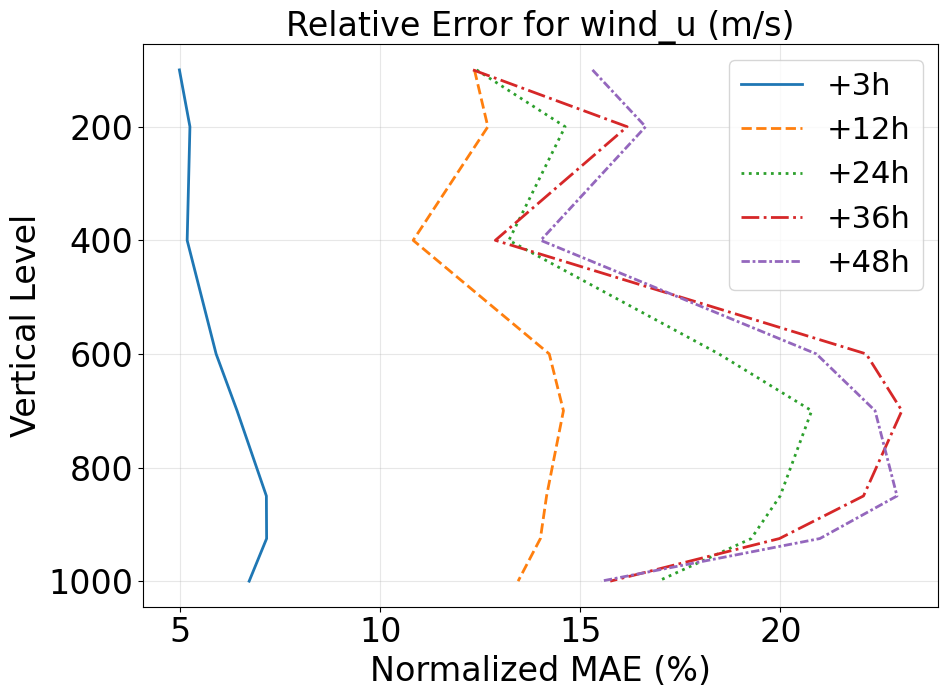

Processing wind_v
Processing duration 3
Processing duration 12
Processing duration 24
Processing duration 36
Processing duration 48


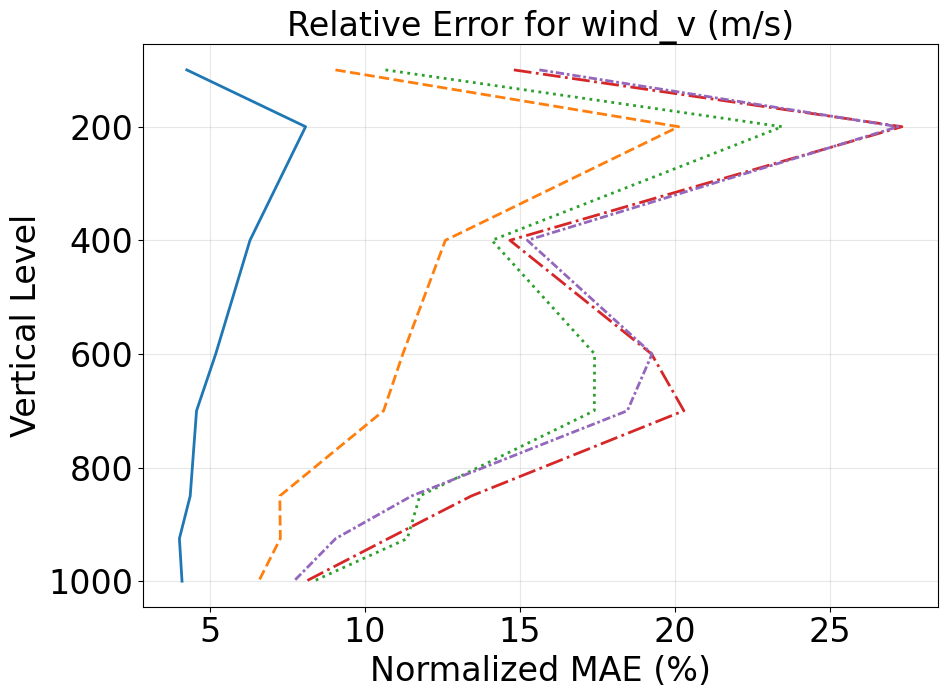

Processing geopotential
Processing duration 3
Processing duration 12
Processing duration 24
Processing duration 36
Processing duration 48


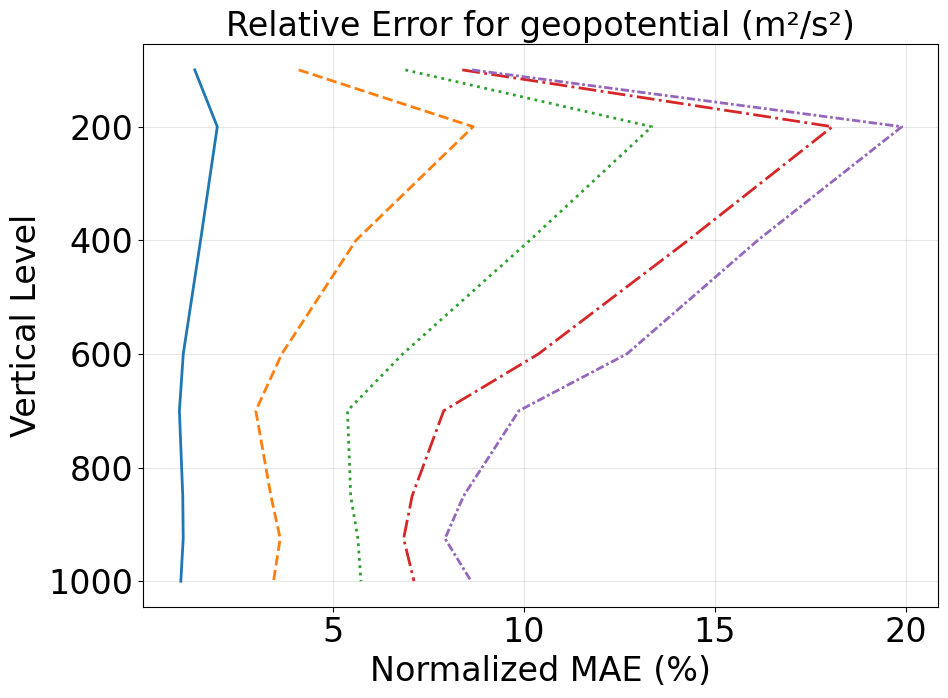

Processing temperature
Processing duration 3
Processing duration 12
Processing duration 24
Processing duration 36
Processing duration 48


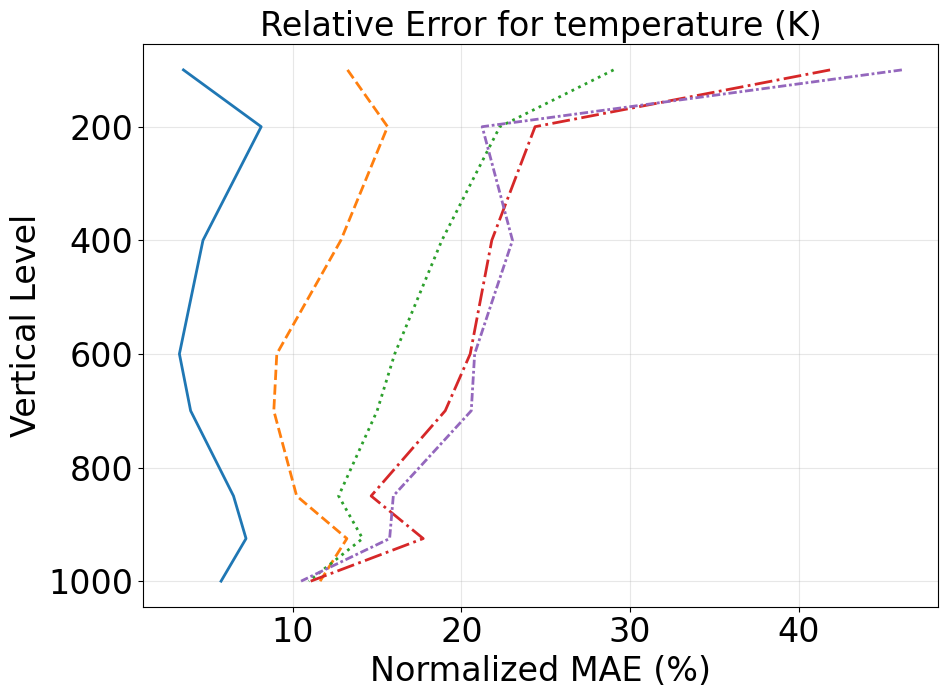

Processing relative_humidity
Processing duration 3
Processing duration 12


KeyboardInterrupt: 

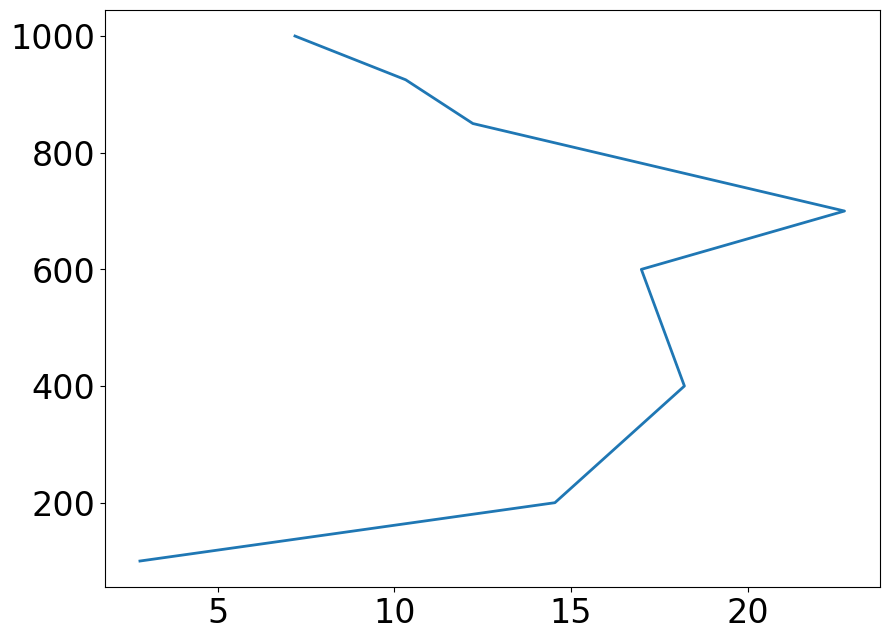

In [11]:
def plot_vertical_errors(ds_gt, ds_ml, variables):
    """
    Plot vertical profiles of relative error for each variable separately.
    Variables with same prefix are stacked along level dimension.
    Shows separate lines for each forecast duration.
    """
    LINESTYLES = [
        "-",
        "--",
        ":",
        "-.",
        (0, (3, 1, 1, 1)),
        (0, (3, 1, 1, 1, 1, 1)),
    ]

    # Group variables by their prefix (without level)
    var_groups = {}

    for var in variables.values():
        #if any(var.startswith(v) for v in VARIABLES_3D):
        if var.endswith("hPa"):
            base_name = "_".join(var.split("_")[:-1])
            level = int(var.split("_")[-1][:-3])

            if base_name not in var_groups:
                var_groups[base_name] = {"vars": [], "levels": []}
            var_groups[base_name]["vars"].append(var)
            var_groups[base_name]["levels"].append(level)
            var_groups[base_name]["unit"] = VARIABLE_UNITS[var]

    if len(var_groups) == 0:
        print("No 3D variables found in the dataset.")
        return

   # Plot each variable separately
    for base_name, group in var_groups.items():
        print("Processing", base_name)
        fig, ax = plt.subplots(figsize=(10, 7.5), dpi=DPI)

        # Sort by level
        sorted_idx = np.argsort(group["levels"])
        sorted_vars = [group["vars"][i] for i in sorted_idx]
        sorted_levels = [group["levels"][i] for i in sorted_idx]

        for dim_idx, elapsed_forecast_dimension in enumerate(
            ds_ml.elapsed_forecast_duration
        ):
            forecast_hours = int(elapsed_forecast_dimension.values / 1e9 / 3600)
            print("Processing duration", forecast_hours)

            # Get observation times for this forecast duration
            obs_times = ds_ml.forecast_time.sel(
                elapsed_forecast_duration=elapsed_forecast_dimension
            )

            # Stack variables for ground truth
            stacked_gt = xr.concat(
                [ds_gt[var].sel(time=obs_times) for var in sorted_vars],
                dim=pd.Index(sorted_levels, name="level"),
            )

            # Stack variables for ML predictions
            stacked_ml = xr.concat(
                [
                    ds_ml[var].sel(
                        elapsed_forecast_duration=elapsed_forecast_dimension
                    )
                    for var in sorted_vars
                ],
                dim=pd.Index(sorted_levels, name="level"),
            )

            # Calculate normalized MAE
            relative_error = (
                abs(stacked_ml - stacked_gt)
                / (
                    stacked_gt.max(dim=["start_time", "x", "y"]) 
                    - stacked_gt.min(dim=["start_time", "x", "y"])
                )
            ).mean(dim=["start_time", "x", "y"]) * 100

            # Plot with different linestyle for each duration
            ax.plot(
                relative_error,
                relative_error.level,
                linewidth=2,
                linestyle=LINESTYLES[dim_idx % len(LINESTYLES)],
                label=f"+{forecast_hours}h",
            )

        unit = group["unit"]
        ax.set_title(f"Relative Error for {base_name} ({unit})")
        ax.set_xlabel("Normalized MAE (%)")
        ax.set_ylabel("Vertical Level")
        ax.grid(True, alpha=0.3)
        ax.invert_yaxis()
        if base_name == list(var_groups.keys())[0]:
            ax.legend()

        plt.tight_layout()
        plt.show()
        save_plot(fig, f"vertical_profile_{base_name}")
        plt.close()

plot_vertical_errors(
    ds_gt,
    ds_ml_sampled.isel(elapsed_forecast_duration=ELAPSED_FORECAST_DURATION_VERTICAL),
    VARIABLES_GROUND_TRUTH,
)